# The `IncliNET` Tutorial


## Introduction

An application with and online web GUI and an easy to access API for determining the inclinations of the spiral galaxies using their optical images.

This program is powered by several deep convolutional neural networks (CNN) implemented in `TensorFlow`. All CNNs are constructed based on the well-known `VGG` structure, where the convolutional filters are of size `3x3`.

![Inclinet_Deployment_flowchart](https://user-images.githubusercontent.com/13570487/134273571-099b9f86-ffb3-450e-94a8-c3262970f51f.png)


### Problem

The inclination of spiral galaxies plays an important role in measurements of their distances using the `Tully-Fisher` relationship. Each galaxy has its own unique morphology, luminosity, and surface brightness profiles. In addition, galaxy images are covered by foreground stars of the Milky Way galaxy. Therefore, it is challenging to design an algorithm that automatically determines the 3D inclination of spiral galaxies. The inclinations of spiral galaxies can be coarsely derived from the ellipticity of apertures used for photometry, assuming that the image of a spiral galaxy is the projection of a disk with the shape of an oblate spheroid. For ~1/3 of spirals, the approximation of axial ratios provides inclination estimates good to better than 5 degrees, with degradation to ~5 degrees for another 1/3. However in ~1/3 of cases, ellipticity-deriven inclinations are problematic for a variety of reasons. Prominent bulges can dominate the axial ratio measurement, with the Sombrero galaxy (scroll down to see an image of [The Sombrero Galaxy](https://cdn.eso.org/images/screen/eso0007a.jpg)) providing an extreme example. Some galaxies may not be axially symmetric due to tidal effects. High surface brightness bars within much lower surface brightness disks can lead to large errors. Simply the orientation of strong spiral features with respect to the tilt axis can be confusing. The statistical derivation of inclinations for large samples has been unsatisfactory.

### Objectives

The task of manual evaluation of spirals inclinations is tedious and time consuming. In the future, with the large astronomical survey telescopes coming online, this task could not be efficiently done manually for thousands of galaxies. The objective of this project is to automatically determine the inclination of spiral galaxies with the human level accuracy providing their images (ideally in both colorful and black-and-white formats).

# Web Application

[https://edd.ifa.hawaii.edu/inclinet/](https://edd.ifa.hawaii.edu/inclinet/)

![GUI_screenshot](./web_gui.png)

On the left side of this tool, users have different options to find and load a galaxy image. The PGC-based query relies on the information provided by the [HyperLEDA](http://leda.univ-lyon1.fr/) catalog. Each image is rotated and resized based on the LEDA entries for `logd25` and position angle (`pa`), which are reasonable in most cases. Further manual alignment features are provided, however the evaluation process is independent of the orientation of the image. Clicking on the `Evaluate` button, the output inclinations generated by various ML models are generated and the average results are displayed on the right side. This step feeds the image to a pre-trained neural network(s) and outputs the averages of the determined inclination value. In addition, there is other networks that separately predict the rejection probability of the galaxy by human users. For practical reasons, all images are converted to square sizes and rescaled to 128x128 pixels prior to the evaluation process.

This online GUI allows users to submit a galaxy image through four different methods, as described below.


## Galaxy PGC ID

Entering the name of a galaxy by querying its PGC number (the ID of galaxy in the Principal Galaxy Catalog)
- The PGC catalog is deployed with our model, and contains a table of galaxy coordinates and their sizes. Images are then queried from the [SDSS quick-look](http://skyserver.sdss.org/dr16/en/tools/quicklook/summary.aspx?) image server.

## Galaxy Name

Searching a galaxy by its common name.
- The entered name is queried through the [NASA/IPAC Extragalactic Database](http://ned.ipac.caltech.edu/). Then, a python routine based on the package [Beautiful Soup](https://beautiful-soup-4.readthedocs.io/en/latest/#) extracts the corresponding PGC number. Once the PGC ID is available, the galaxy image is imported from the *SDSS quick-look* as explained above.

![Screenshot from 2021-09-08 03-09-36](https://user-images.githubusercontent.com/13570487/132490712-c39440bc-9b41-4a3e-bb54-1c4fb0de2c30.png)


## Galaxy Coordinates

Looking at a specific location in the sky by entering the sky coordinates and the field size. In the first release we only provide access to the `SDSS` images, if they are available. [The SDSS coverage](https://www.sdss.org/dr16/) is mainly limited to the Northern sky.
 
## Galaxy Image

Uploading a galaxy image from the local computer of the user.
- User has the option of uploading a galaxy image for evaluation by our model(s)


# API

We provide a `REST API` that can be called from terminal or other applications that enable the `REST API` calls. The input and output data would be in JSON format.

## Example 1:  /api/pgc/

### Sending a request with the galaxy ID 

Evaluating inclination based on the `PGC ID` of the target galaxy. Here we test the API for *pgc=69327*.

- On average, there is ~7% that a human user rejects this galaxy.
- The median of all evaluated inclinations is 75 degree (from face-on).

Text(0.5, 1.0, 'NGC7331')

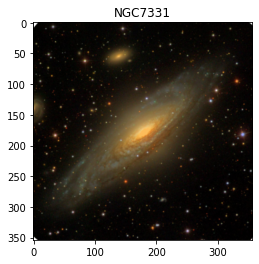

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('./PGC69327_NGC7331.png')
plt.imshow(img)
plt.title("NGC7331")

In [2]:
! curl http://edd.ifa.hawaii.edu/inclinet/api/pgc/69327

{
  "status": "success",
  "galaxy": {
    "pgc": "69327",
    "ra": "339.2673 deg",
    "dec": "34.4156 deg",
    "fov": "14.00 arcmin",
    "pa": "169.0 deg",
    "objname": "NGC7331"
  },
  "inclinations": {
    "Group_0": {
      "model4": 75.0,
      "model41": 76.0,
      "model42": 74.0,
      "model43": 74.0
    },
    "Group_1": {
      "model5": 76.0,
      "model51": 76.0,
      "model52": 75.0,
      "model53": 73.0
    },
    "Group_2": {
      "model6": 75.0,
      "model61": 77.0,
      "model62": 76.0,
      "model63": 75.0
    },
    "summary": {
      "mean": 75.16666666666667,
      "median": 75.0,
      "stdev": 1.0671873729054746
    }
  },
  "rejection_likelihood": {
    "model4-binary": 13.275855779647827,
    "model5-binary": 0.4835432395339012,
    "model6-binary": 2.4772919714450836,
    "summary": {
      "mean": 5.412230330208938,
      "median": 2.4772919714450836,
      "stdev": 5.619680442177983
    }
  }
}


### Erroneous PGC ID

or an ID that doesn't exist

In [3]:
! curl http://edd.ifa.hawaii.edu/inclinet/api/pgc/xxxx

{"message":"Could not find PGCxxxx in the database. ","status":"failed"}


## Example 2:  /api/objname

### Sending a request with the galaxy name 

Evaluating inclination based on the `Galaxy Name`. Here we test the API for 'Sombrero'.

- On average, there is ~44% that a human user rejects this galaxy. However the descrepancies between different models is quites large, as 1$\sigma$ standard devaition of the rejection likelihoods is ~20%. It would be suggested that a human overlooks the automatically determined inclination for this galaxy.

- [Click here](http://edd.ifa.hawaii.edu/inclination/practice.php?pgc=42407) for the manual evaluations on [Galaxy Inclination Zoo](http://edd.ifa.hawaii.edu/inclination).

- The median of all evaluated inclinations is 89 degree (from face-on).

Text(0.5, 1.0, 'The Sombrero Galaxy (M104)')

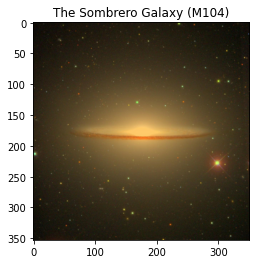

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('./sombrero.png')
plt.imshow(img)
plt.title("The Sombrero Galaxy (M104)")

In [5]:
! curl http://edd.ifa.hawaii.edu/inclinet/api/objname/Sombrero

{
  "status": "success",
  "galaxy": {
    "pgc": 42407,
    "ra": "189.9977 deg",
    "dec": "-11.6230 deg",
    "fov": "12.77 arcmin",
    "pa": "89.5 deg",
    "objname": "Sombrero"
  },
  "inclinations": {
    "Group_0": {
      "model4": 89.0,
      "model41": 89.0,
      "model42": 75.0,
      "model43": 85.0
    },
    "Group_1": {
      "model5": 87.0,
      "model51": 90.0,
      "model52": 88.0,
      "model53": 88.0
    },
    "Group_2": {
      "model6": 90.0,
      "model61": 90.0,
      "model62": 88.0,
      "model63": 90.0
    },
    "summary": {
      "mean": 87.41666666666667,
      "median": 88.5,
      "stdev": 4.009537241239803
    }
  },
  "rejection_likelihood": {
    "model4-binary": 59.36983823776245,
    "model5-binary": 14.682640135288239,
    "model6-binary": 60.917991399765015,
    "summary": {
      "mean": 44.99015659093857,
      "median": 59.36983823776245,
      "stdev": 21.439968280999413
    }
  }
}


### Wrong galaxy name

or a name that can not be recognized/parsed from [NED](https://ned.ipac.caltech.edu/).

In [6]:
! curl http://edd.ifa.hawaii.edu/inclinet/api/objname/myGalaxy

{"message":"Could not find oject myGalaxy.","status":"failed"}


## Example 3:  /api/file

### Sending a request with the galaxy image

Evaluating inclination using the `Galaxy Image`. Here, we test the API for 'Andromeda'.

- On average, there is ~4% that a human user rejects this galaxy.
- The median of all evaluated inclinations is 76 degree (from face-on).

Text(0.5, 1.0, 'Andromeda')

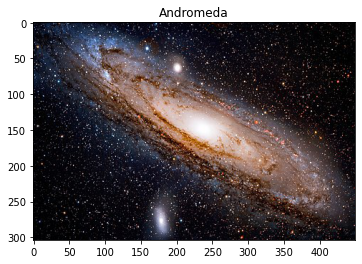

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('./andromeda.jpg')
plt.imshow(img)
plt.title("Andromeda")

In [8]:
! curl -F 'file=@./andromeda.jpg' http://edd.ifa.hawaii.edu/inclinet/api/file

{
  "status": "success",
  "filename": "andromeda.jpg",
  "inclinations": {
    "Group_0": {
      "model4": 77.0,
      "model41": 79.0,
      "model42": 76.0,
      "model43": 76.0
    },
    "Group_1": {
      "model5": 73.0,
      "model51": 76.0,
      "model52": 75.0,
      "model53": 72.0
    },
    "Group_2": {
      "model6": 78.0,
      "model61": 76.0,
      "model62": 77.0,
      "model63": 78.0
    },
    "summary": {
      "mean": 76.08333333333333,
      "median": 76.0,
      "stdev": 1.9346977943739831
    }
  },
  "rejection_likelihood": {
    "model4-binary": 9.210722893476486,
    "model5-binary": 34.75632667541504,
    "model6-binary": 8.197003602981567,
    "summary": {
      "mean": 17.3880177239577,
      "median": 9.210722893476486,
      "stdev": 12.28821993007762
    }
  }
}


### Wrong file name

In [9]:
! curl -F 'file=@./myGalaxy.jpg' http://edd.ifa.hawaii.edu/inclinet/api/file

curl: (26) Failed to open/read local data from file/application


### Wrong file format

In [10]:
! curl -F 'file=@./myGalaxy.txt' http://edd.ifa.hawaii.edu/inclinet/api/file

{"filename":"myGalaxy.txt","message":"[Note] Please upload jpg, png, jpeg, and gif giles no larger than 1 MB !","status":"failed"}


## Example 4: */getPGC* 

### Get information about the galaxy providing the PGC ID

`PGC 2557` is the code of the `Andromeda` galaxy.

In [11]:
! curl -X 'POST' \
      'http://edd.ifa.hawaii.edu/inclinet/getPGC' \
      -H 'accept: application/json' \
      -H 'Content-Type: application/json' \
      -d '{"pgc": 2557}'

{"dec":"41.2689","fov":"266.74","objname":"NGC0224","pa":"35.0","pgc":2557,"ra":"10.6848","status":"success"}


### Generating a wrong API call

Cases when the requested PGC ID is not available, or an error occurs in the API call

In [12]:
! curl -X 'POST' \
      'http://edd.ifa.hawaii.edu/inclinet/getPGC' \
      -H 'accept: application/json' \
      -H 'Content-Type: application/json' \
      -d '{"pgc": 20505070}'

{"status":"error"}


## Example 5: */getObj* 

### Get information about the galaxy providing its common name

`M31` is the alternative name of `Andromeda` in the Messier catalog.

In [13]:
! curl -X 'POST' \
      'http://edd.ifa.hawaii.edu/inclinet/getObj' \
      -H 'accept: application/json' \
      -H 'Content-Type: application/json' \
      -d '{"objname": "M31"}'

{"dec":"41.2689","fov":"266.74","objname":"M31","pa":"35.0","pgc":2557,"ra":"10.6848","status":"success"}


### Generating a wrong API call

Cases when the requested galaxy name is not available, or an error occurs in the API call

In [14]:
! curl -X 'POST' \
      'http://edd.ifa.hawaii.edu/inclinet/getObj' \
      -H 'accept: application/json' \
      -H 'Content-Type: application/json' \
      -d '{"objname": "myGalaxy"}'

{"status":"error"}


## Related Topics

- For further details on various VGG models we considered in this project [click here](https://github.com/ekourkchi/incNET-data/tree/master/incNET_VGGcnn_withAugmentation).
- [Visit here](https://github.com/ekourkchi/inclinet_production_repo/blob/main/Inclinet_Deployment_Architecture.pdf) to get the full picture of the deployment plan.
- [The Production Pipeline](https://github.com/ekourkchi/inclinet_production_repo)
- [Project proposal and motivations](https://github.com/ekourkchi/incNET-data)
- [Data Preprocessing](https://github.com/ekourkchi/incNET-data/blob/master/incNET_dataPrep/incNET_dataClean.ipynb) in order to get reliable labels
- On how to download data from the SDSS image service and preprocess them [click here](https://github.com/ekourkchi/SDSS_get)

## About the data

All data exposed by the *IncliNET* project belongs to 

- Cosmicflows-4 program
- Copyright (C) Cosmicflows
- Team - The Extragalactic Distance Database (EDD)

## Author

- Ehsan Kourkchi - [ekourkchi@gmail.com](ekourkchi@gmail.com)

## Disclaimer <a name="Disclaimer"></a>

 * All rights reserved. The material may not be used, reproduced or distributed, in whole or in part, without the prior agreement. 